---
title: "Titulo"
summary: |
    Resumen
date: "2025-09-25"
#image: imgs/thomas_bayes_mate.png
lang: en
---

In [ ]:
#| code-fold: true
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import pytensor.tensor as pt

c_orange = "#f08533"
c_blue = "#3b78b0"
c_red = "#d1352c"

Mientras *scrapeaba* datos sobre los tiros libres de los *rookies* en la NBA durante la temporada 2024-25, me encontré con [este artículo](https://link.springer.com/article/10.1007/s12662-020-00646-x), donde se concluye que existe un efecto de “precalentamiento”: los jugadores de básquet tienden a fallar más los primeros disparos que el resto. El hallazgo me pareció interesante y lógico, y empecé a preguntarme si valía la pena realizar un análisis similar con los datos que estaba recolectando.
Y bueno, acá estamos.

## Los datos

El siguiente *data frame* contiene información sobre los tiros libres realizados por los *rookies* de la temporada 2024-25 de la NBA.
En este caso, las columnas relevantes son la identificación del jugador (`player_id`), el orden del disparo (`description`) y si el lanzamiento fue convertido (`success`).

In [2]:
df = (
    pl.read_parquet("data.parquet")
    .select("game_date", "matchup", "player_id", "player_name", "description", "success")
)
df

game_date,matchup,player_id,player_name,description,success
date,str,i32,str,str,bool
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 1 of 2""",false
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 2 of 2""",false
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 1""",true
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 2""",false
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 2 of 2""",true
…,…,…,…,…,…
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 1 of 2""",true
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 2 of 2""",true
2025-03-12,"""MEM vs. UTA""",1641744,"""Edey, Zach""","""Free Throw 1 of 1""",false


En la NBA, los tiros libres pueden darse en series de 1, 2 o 3 intentos. Nuestra primera tarea es mapear los valores de `description` a un valor numérico que represente el orden del disparo dentro de su serie.

In [3]:
throw_order = {
    "Free Throw 1 of 1": 1,
    "Free Throw 1 of 2": 1,
    "Free Throw 1 of 3": 1,
    "Free Throw 2 of 2": 2,
    "Free Throw 2 of 3": 2,
    "Free Throw 3 of 3": 3,
    "Free Throw Clear Path 1 of 2": 1,
    "Free Throw Clear Path 2 of 2": 2,
    "Free Throw Flagrant 1 of 1": 1,
    "Free Throw Flagrant 1 of 2": 1,
    "Free Throw Flagrant 2 of 2": 2,
    "Free Throw Technical": 1,
}

df = df.with_columns(
    pl.col("description").replace_strict(throw_order, return_dtype=pl.Int64).alias("order")
)
df

game_date,matchup,player_id,player_name,description,success,order
date,str,i32,str,str,bool,i64
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 1 of 2""",false,1
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 2 of 2""",false,2
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 1""",true,1
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 2""",false,1
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 2 of 2""",true,2
…,…,…,…,…,…,…
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 1 of 2""",true,1
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 2 of 2""",true,2
2025-03-12,"""MEM vs. UTA""",1641744,"""Edey, Zach""","""Free Throw 1 of 1""",false,1


Podemos observar que los primeros intentos suelen fallarse con mayor frecuencia que los segundos, y que estos, a su vez, se fallan más que los terceros.

In [ ]:
df_summary = (
    df
    .group_by("order")
    .agg(pl.col("success").sum().alias("y"), pl.len().alias("n"))
    .with_columns((pl.col("y") / pl.col("n")).alias("p"))
    .sort("order")
)
df_summary

order,y,n,p
i64,u32,u32,f64
1,1435,2069,0.693572
2,1227,1625,0.755077
3,23,28,0.821429


## Modelo agrupado

Como primer paso, utilizamos un modelo que agrupa los disparos de todos los jugadores, los considera equivalentes, más de lo mismo.
Definimos $Y_1$ como la cantidad de aciertos en primeros disparos y $Y_2$ como la cantidad de aciertos en segundos disparos.
Luego, $\pi_1$ representa la probabilidad de acertar en un primer intento y $\pi_2$ en un segundo.

$$
\begin{aligned}
Y_1 &\sim \text{Binomial}(N_1, \pi_1) \\
Y_2 &\sim \text{Binomial}(N_2, \pi_2) \\
\pi_1 &\sim \text{Beta}(4, 2) \\
\pi_2 &\sim \text{Beta}(4, 2) \\
\end{aligned}
$$

En PyMC, tenemos:

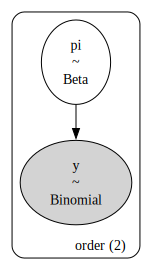

In [29]:
y = df_summary.head(2)["y"].to_numpy()
n = df_summary.head(2)["n"].to_numpy()

with pm.Model(coords={"order": [1, 2]}) as model:
    pi = pm.Beta("pi", alpha=4, beta=2, dims="order")
    y = pm.Binomial("y", p=pi, n=n, observed=y, dims="order")
    idata = pm.sample(chains=4, random_seed=1211, nuts_sampler="nutpie", progressbar=False)

model.to_graphviz()

Calculamos $\delta$ como la diferencia entre $\pi_2$ y $\pi_1$, y analizamos las distribuciones marginales *a posteriori*.

En primer lugar, los diagnósticos no indican problemas en el muestreo: $\hat{R}$ cercano a 1, tamaños efectivos de muestra adecuados, etc.

In [31]:
#| classes: .center-table-70
idata.posterior["delta"] = idata.posterior["pi"].sel(order=2) - idata.posterior["pi"].sel(order=1)
az.summary(idata, var_names=["pi", "delta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[1],0.694,0.010,0.673,0.712,0.0,0.0,4040.0,2880.0,1.0
pi[2],0.754,0.011,0.733,0.773,0.0,0.0,3996.0,2737.0,1.0
delta,0.061,0.015,0.030,0.088,0.0,0.0,4193.0,2918.0,1.0


Si nos enfocamos en la distribución _a posteriori_ de $\delta$, podemos ver que la probabilidad de que $\delta$ sea mayor a 0 es igual a 1.
Así, llegamos a nuestra primera gran conclusión: efectivamente, la probabilidad de acertar en el segundo intento es mayor que en el primero.

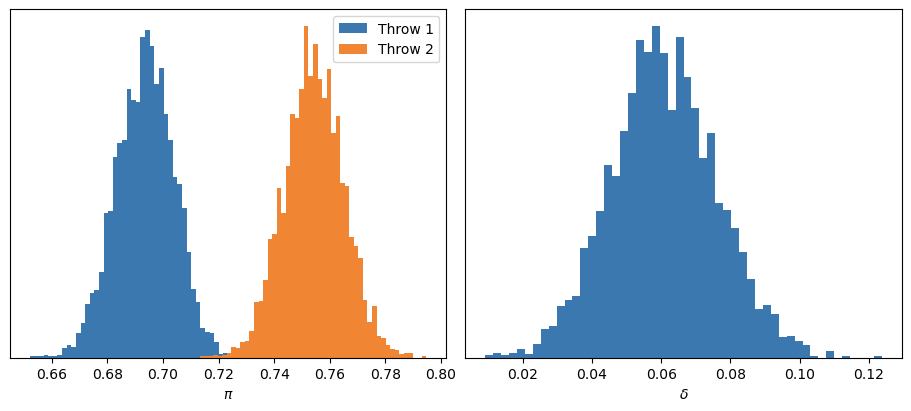

In [32]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

axes[0].hist(idata.posterior.pi.sel(order=1).values.ravel(), bins=50, color=c_blue, label="Throw 1")
axes[0].hist(idata.posterior.pi.sel(order=2).values.ravel(), bins=50, color=c_orange, label="Throw 2")
axes[1].hist(idata.posterior.delta.values.ravel(), bins=50, color=c_blue)

axes[0].set(xlabel="$\\pi$", yticks=[])
axes[0].legend()
axes[1].set(xlabel="$\\delta$", yticks=[]);

## Modelo parcialmente agrupado

El modelo anterior solo nos permite concluir que es más probable que un _rookie_ acierte un segundo lanzamiento que un primero.
Ahora, vamos a implementar un modelo jerárquico, en el cuál cada jugador tiene su propia probabilidad de acertar un primer o un segundo lanzamiento.

In [ ]:
#| classes: .center-table-40
df_agg = (
    df
    .group_by("player_id", "order")
    .agg(
        pl.col("success").sum().alias("y"),
        pl.len().alias("n")
    )
    .sort("player_id", "order")
)
selected_ids = (
    df_agg
    .filter(pl.col("order") == 2, pl.col("n") > 0)
    .get_column("player_id")
    .unique()
    .to_list()
)

df_model = (
    df_agg
    .filter(pl.col("player_id").is_in(selected_ids), pl.col("order") < 3)
    .sort("player_id", "order")
)
df_model

player_id,order,y,n
i32,i64,u32,u32
1630283,1,1,5
1630283,2,5,5
1630542,1,4,5
1630542,2,4,5
1630545,1,9,12
…,…,…,…
1642502,2,1,2
1642505,1,1,1
1642505,2,1,1


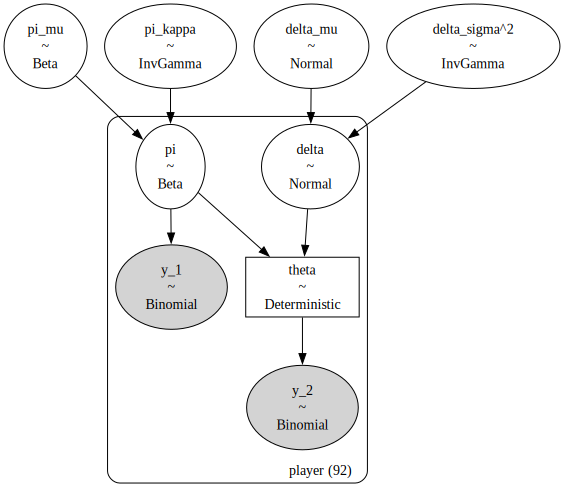

In [ ]:
y_1 = df_model.filter(pl.col("order") == 1)["y"].to_numpy()
y_2 = df_model.filter(pl.col("order") == 2)["y"].to_numpy()

n_1 = df_model.filter(pl.col("order") == 1)["n"].to_numpy()
n_2 = df_model.filter(pl.col("order") == 2)["n"].to_numpy()

player_ids = df_model["player_id"].unique(maintain_order=True)
N = len(player_ids)
coords = {"player": player_ids}

with pm.Model(coords=coords) as model_h:
    pi_mu = pm.Beta("pi_mu", alpha=4, beta=2)
    pi_kappa = pm.InverseGamma("pi_kappa", alpha=0.5 * 15, beta=0.5 * 15 * 10)
    pi_alpha = pi_mu * pi_kappa
    pi_beta = (1 - pi_mu) * pi_kappa
    pi = pm.Beta("pi", alpha=pi_alpha, beta=pi_beta, dims="player")

    delta_mu = pm.Normal("delta_mu", mu=0, sigma=0.15)
    delta_sigma = pm.InverseGamma("delta_sigma^2", 0.5 * 30, 0.5 * 30 * 0.05 ** 2) ** 0.5
    delta = pm.Normal(
        "delta",
        mu=delta_mu,
        sigma=delta_sigma,
        dims="player",
        initval=np.zeros(N)
    )

    theta = pm.Deterministic("theta", pt.clip(pi + delta, 0.0001, 0.9999), dims="player")

    pm.Binomial("y_1", p=pi, n=n_1, observed=y_1, dims="player")
    pm.Binomial("y_2", p=theta, n=n_2, observed=y_2, dims="player")

model_h.to_graphviz()

In [ ]:
#| classes: .center-table-70
with model_h:
    idata_h = pm.sample(
        chains=4,
        target_accept=0.99,
        nuts_sampler="nutpie",
        random_seed=1211,
        progressbar=False,
    )

az.summary(idata_h, var_names=["pi_mu", "pi_kappa", "delta_mu", "delta_sigma^2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi_mu,0.698,0.015,0.670,0.727,0.000,0.000,1063.0,2206.0,1.00
pi_kappa,28.903,9.035,14.499,45.731,0.286,0.278,1001.0,1623.0,1.00
delta_mu,0.055,0.016,0.027,0.086,0.001,0.000,497.0,910.0,1.01
delta_sigma^2,0.002,0.001,0.001,0.003,0.000,0.000,1262.0,2006.0,1.00


In [ ]:
#| echo: false
players = (
    df_model
    .filter(pl.col("order") == 1)
    .unique("n")
    .sort("n")
    .get_column("player_id")
    .to_numpy()
)
players = np.concatenate([players[:(len(players ) - 10):2], players[-10:]])
for player in players:
    player_name = df.filter(pl.col("player_id") == player).get_column("player_name").unique().item()
    print("-", player, player_name)

-  1630762 Wheeler, Phillip
-  1641989 Harkless, Elijah
-  1630283 Kelley, Kylor
-  1630574 Hukporti, Ariel
-  1642265 Dillingham, Rob
-  1641736 Beekman, Reece
-  1642277 Furphy, Johnny
-  1631232 Brooks Jr., Keion
-  1641810 Reeves, Antonio
-  1642348 Edwards, Justin
-  1642272 McCain, Jared
-  1641783 da Silva, Tristan
-  1642347 Shead, Jamal
-  1642266 Walter, Ja'Kobe
-  1642273 George, Kyshawn
-  1641824 Buzelis, Matas
-  1642270 Clingan, Donovan
-  1641842 Holland II, Ronald
-  1642377 Wells, Jaylen
-  1641744 Edey, Zach
-  1642271 Filipowski, Kyle
-  1642258 Risacher, Zaccharie
-  1642268 Collier, Isaiah
-  1642259 Sarr, Alex
-  1642274 Missi, Yves
-  1642264 Castle, Stephon


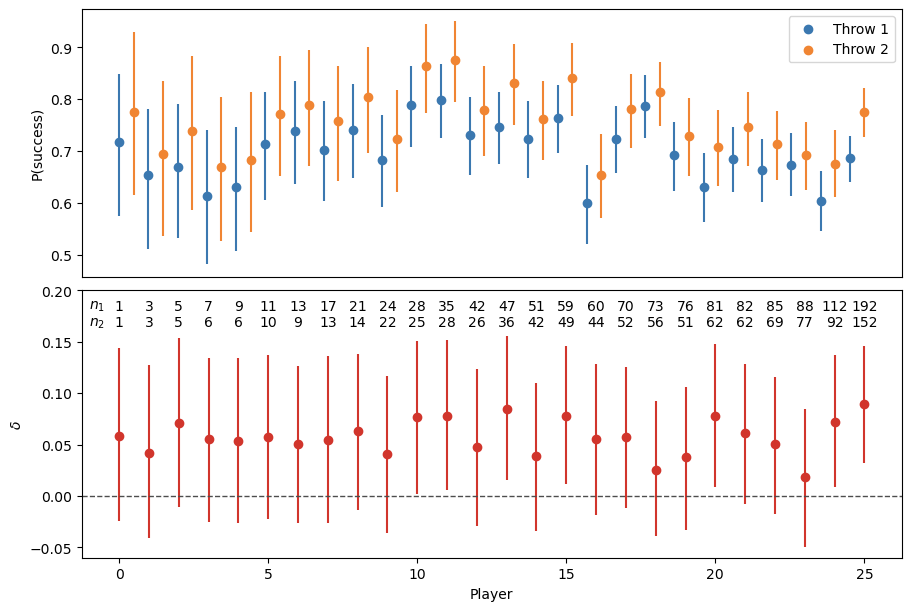

In [ ]:
#| echo: false
posterior_players = idata_h.posterior.sel(player=players)
pi_mean = posterior_players["pi"].mean(("chain", "draw")).to_numpy()
pi_ci = posterior_players["pi"].quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

theta_mean = posterior_players["theta"].mean(("chain", "draw")).to_numpy()
theta_ci = posterior_players["theta"].quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

delta_mean = posterior_players["delta"].mean(("chain", "draw")).to_numpy()
delta_ci = posterior_players["delta"].quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

x_label = (
    df_model
    .filter(pl.col("player_id").is_in(players))
    .pivot(on="order", index="player_id", values=["y", "n"])
    .sort("n_1")
    .with_columns(
        pl.concat_str(pl.col("n_1", "n_2"), separator = "\n").alias("label")
    )
    .get_column("label")
    .to_list()
)

x = np.arange(len(players))

fig, axes = plt.subplots(2, 1, figsize=(9, 6), layout="constrained")

axes[0].scatter(x - 0.25, pi_mean, color=c_blue, label="Throw 1")
axes[0].vlines(x - 0.25, pi_ci[0], pi_ci[1], color=c_blue)
axes[0].scatter(x + 0.25, theta_mean, color=c_orange, label="Throw 2")
axes[0].vlines(x + 0.25, theta_ci[0], theta_ci[1], color=c_orange)
axes[0].set(xticks=[], ylabel="P(success)")
axes[0].legend()


axes[1].scatter(x, delta_mean, color=c_red)
axes[1].vlines(x, delta_ci[0], delta_ci[1], color=c_red)
axes[1].axhline(0, ls="--", color="0.3", lw=1)
axes[1].set(xlabel="Player", ylabel="$\\delta$", ylim=[-0.06, 0.20]);

for x_i, x_l in zip(x, x_label):
    axes[1].text(x_i, 0.165, x_l, size=10, ha="center")

axes[1].text(-0.75, 0.165, "$n_1$\n$n_2$", size=10, ha="center");

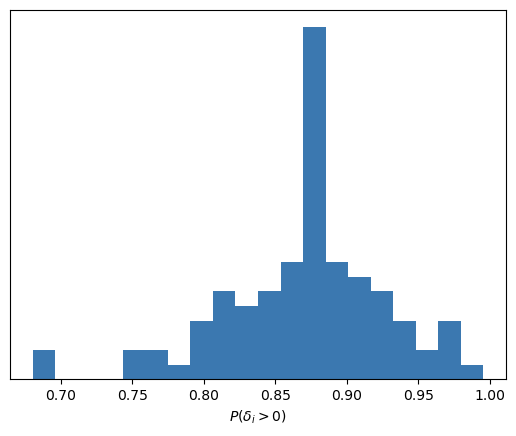

In [ ]:
#| echo: false
fig, ax = plt.subplots()
p_delta = (idata_h.posterior["delta"] > 0).mean(("chain", "draw")).to_numpy()
ax.hist(p_delta, bins=20, color=c_blue)
ax.set(yticks=[], xlabel="$P(\\delta_i > 0)$");

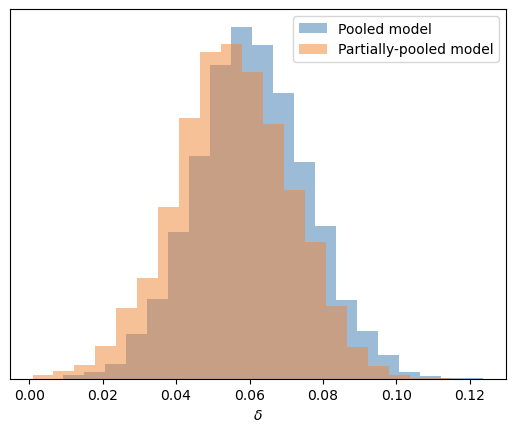

In [ ]:
#| echo: false
fig, ax = plt.subplots()

delta_1 = idata.posterior["delta"].to_numpy().flatten()
delta_2 = idata_h.posterior["delta_mu"].to_numpy().flatten()

ax.hist(delta_1, bins=20, color=c_blue, alpha=0.5, label="Pooled model")
ax.hist(delta_2, bins=20, color=c_orange, alpha=0.5, label="Partially-pooled model")
ax.set(yticks=[], xlabel="$\\delta$")
ax.legend();